# Multiple Linear Regression

This notebook uses python (primarily the [statsmodels](https://www.statsmodels.org) package) to demonstrate multiple linear regression with data for the [UK Referendum on Leaving the EU](https://en.wikipedia.org/wiki/2016_United_Kingdom_European_Union_membership_referendum). The notebook assumes you have first completed the Multiple Linear Regression notebook using UK climate data (which covers Influence and Leverage in detail). 

# Explaining Brexit

In the lead up to the [UK referendum on leaving the EU in 2016](https://en.wikipedia.org/wiki/2016_United_Kingdom_European_Union_membership_referendum) (aka the Brexit vote), many people - including [Geographers](https://blogs.lse.ac.uk/politicsandpolicy/can-we-really-not-predict-who-will-vote-for-brexit-and-where/) - tried to predict the outcome based on [opinion polls](https://en.wikipedia.org/wiki/Opinion_polling_for_the_United_Kingdom_European_Union_membership_referendum). After the vote, many studies have been conducted to identify the key factors that influenced people to vote the way they did, using opinion polls and interviews with individuals, but also using aggregated statistical data. This notebook presents a basic example of analysing quantitative data, aggregated at Local Authority District level for England, using multiple regression modelling and a model selection approach.   

Before deciding what data to include in the modelling, a brief literature review of similar previous analysis was conducted. Examples of findings are:

- [Harris and Charlton](https://doi.org/10.1177/0308518X16665844) (2016) found _"Areas with an older population were more likely to attract a higher share of the Leave vote, as were those with higher proportions of residents in lower supervisory and technical occupations, and with residents born outside of the UK but in the European Union."_  
- [Manley et al.](https://doi.org/10.1177/0269094217705248) (2017) cite [Goodwin and Heath](https://doi.org/10.1111/1467-923X.12285) (2016) who _"reported that 68% of variation in the percentage voting Leave was positively related to the percentage of people aged 65 and over in a local authority and to the percentage of residents there with no educational qualifications"_
- [Darvas](https://blogs.lse.ac.uk/brexit/2016/08/31/brexit-should-be-a-wake-up-call-in-the-fight-against-inequality/) (2016) used regression analysis to examine the influence of age, education, income, immigration, income inequality, poverty, unemployment and geographical factors, finding that _"in areas where income inequality and poverty are higher, there were more ‘leave’ votes, even after controlling for the influences of socio-economic and geographic factors."_

Based on this literature, the following variables and data were sourced for analysis:

- Electoral Comission data on Brexit vote percentages at the local authority level. [[via Rey et al. (2020)](https://geographicdata.science/book/data/brexit/brexit_cleaning.html)]
- ONS Local Authority Districts (December 2016) Generalised Clipped Boundaries in the UK WGS84. [[via Rey et al. (2020)](https://geographicdata.science/book/data/brexit/brexit_cleaning.html)]
- UK 2011 Census data on qualifications and students for local authorities in England and Wales (Table KS501EW) [[from ONS](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/2011censuskeystatisticsforlocalauthoritiesinenglandandwales)]
- UK 2011 Census data on Age structure for local authorities in England and Wales (Table KS102EW) [[from ONS](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/2011censuskeystatisticsforlocalauthoritiesinenglandandwales)]

## Setup

Load required packages

In [1]:
# Graphics
import matplotlib.pyplot as plt

# Analysis
import geopandas as gpd
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

Read data file containing age, qualifications and brexit voting information (some data wrangling was needed to create this file from the original sources):

In [2]:
england_data_path = '../../data/brexit/england_age_qual_vote.csv'
england = pd.read_csv(england_data_path, index_col='Area_Code')
england.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326 entries, E06000001 to E09000033
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area_age                 326 non-null    object 
 1   Count_Persons_age        326 non-null    object 
 2   Pct_0-4                  326 non-null    float64
 3   Pct_5-7                  326 non-null    float64
 4   Pct_8-9                  326 non-null    float64
 5   Pct_10-14                326 non-null    float64
 6   Pct_15                   326 non-null    float64
 7   Pct_16-17                326 non-null    float64
 8   Pct_18-19                326 non-null    float64
 9   Pct_20-24                326 non-null    float64
 10  Pct_25-29                326 non-null    float64
 11  Pct_30-44                326 non-null    float64
 12  Pct_45-59                326 non-null    float64
 13  Pct_60-64                326 non-null    float64
 14  Pct_65-74        

Read spatial data

In [3]:
lads = gpd.read_file("../../data/brexit/local_authority_districts.geojson").set_index('lad16cd')
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


Merge data (use index from both DataFrames)

In [4]:
Egdf = lads.merge(england, how='inner', 
                  left_index=True, right_index=True)

#gdf = gpd.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)

Check data has loaded correctly

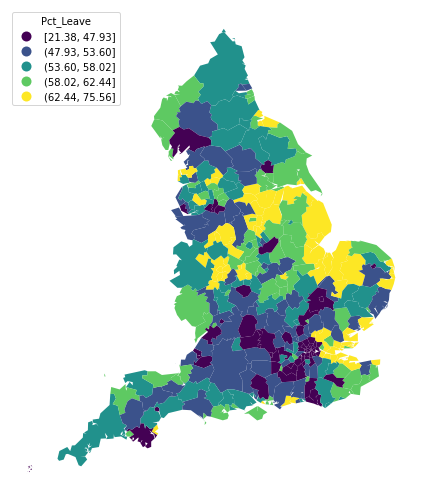

In [5]:
col='Pct_Leave' 
fig, ax = plt.subplots(1, figsize=(9, 9))
Egdf.plot(column=col, cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":col,"loc": 2},
        ax=ax
       )
ax.set_axis_off()

# Univariate Relations

## University-level qualifications

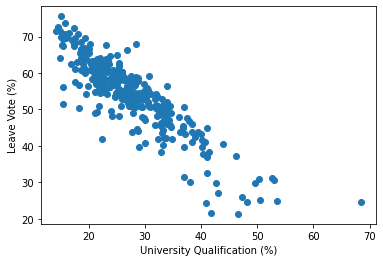

In [6]:
fig, ax = plt.subplots(1)
plt.scatter(Egdf['Pct_Level4'],Egdf['Pct_Leave'])
ax.set_ylabel('Leave Vote (%)')
ax.set_xlabel('University Qualification (%)')
plt.show()

In [7]:
l4_mod = smf.ols("Pct_Leave ~ Pct_Level4", data=Egdf)
l4_mod_fit = l4_mod.fit()
print(l4_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Pct_Leave   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     1128.
Date:                Thu, 18 Mar 2021   Prob (F-statistic):          1.51e-107
Time:                        10:11:00   Log-Likelihood:                -968.77
No. Observations:                 326   AIC:                             1942.
Df Residuals:                     324   BIC:                             1949.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     84.7678      0.939     90.305      0.0

Check results - is this a useful model? 

Yes:

- regression coefficient is significant (at 99% confidence)
- high $r^2$
- clear effect (1.1% lower leave vote for every 1% more people with a University qualification)

What about model diagnostics to check assumptions have been met?

Text(0, 0.5, 'Count')

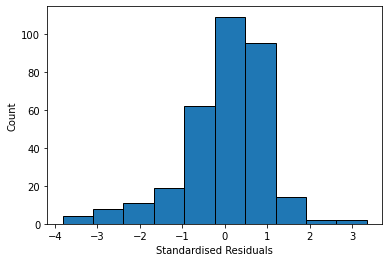

In [8]:
plt.hist(l4_mod_fit.resid_pearson,
         edgecolor='black')
plt.xlabel('Standardised Residuals')
plt.ylabel('Count')

Text(0, 0.5, 'Standardized Residuals (z)')

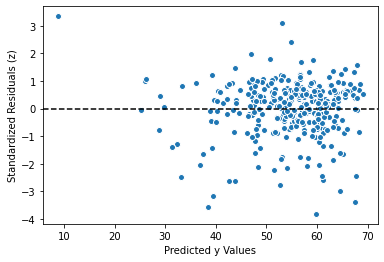

In [9]:
plt.plot(l4_mod_fit.fittedvalues, l4_mod_fit.resid_pearson, 
         'oC0',  
         markeredgecolor='white')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Predicted y Values')
plt.ylabel('Standardized Residuals (z)')   

We have n = 326 so normality not an issue. Residuals look relatively homogenous. 

## Age

Create a new variable of percentage of people 65+

In [10]:
old = Egdf[['Pct_65-74','Pct_75-84','Pct_85-89','Pct_90p']]
Egdf['Pct_65p'] = old.sum(axis=1)
#check
Egdf[['Pct_65-74','Pct_75-84','Pct_85-89','Pct_90p','Pct_65p']].head()

,Pct_65-74,Pct_75-84,Pct_85-89,Pct_90p,Pct_65p
E06000001,8.9,6.1,1.4,0.6,17.0
E06000002,7.8,5.3,1.2,0.6,14.9
E06000003,10.7,6.5,1.6,0.7,19.5
E06000004,8.4,5.4,1.3,0.5,15.6
E06000010,7.1,5.0,1.2,0.6,13.9


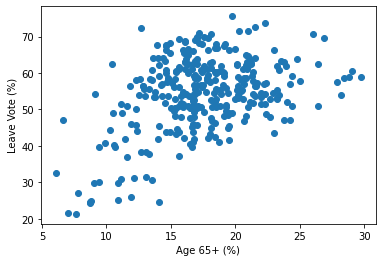

In [11]:
fig, ax = plt.subplots(1)
plt.scatter(Egdf['Pct_65p'],Egdf['Pct_Leave'])
ax.set_ylabel('Leave Vote (%)')
ax.set_xlabel('Age 65+ (%)')
plt.show()

In [12]:
p65_mod = smf.ols("Pct_Leave ~ Pct_65p", data=Egdf)
p65_mod_fit = p65_mod.fit()
print(p65_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Pct_Leave   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     70.91
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           1.23e-15
Time:                        10:11:01   Log-Likelihood:                -1181.0
No. Observations:                 326   AIC:                             2366.
Df Residuals:                     324   BIC:                             2374.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3423      2.214     16.412      0.0

Check results - is this a useful model? 

Yes:

- regression coefficient is significant (at 99% confidence)
- okay $r^2$
- clear effect (1.1% lower leave vote for every 1% more people with age 65+)

What about assumptions?

Text(0, 0.5, 'Count')

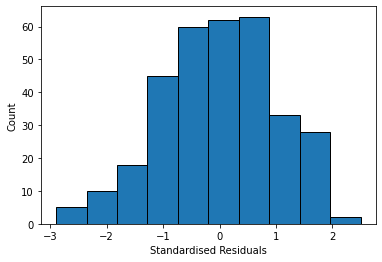

In [13]:
plt.hist(p65_mod_fit.resid_pearson,
         edgecolor='black')
plt.xlabel('Standardised Residuals')
plt.ylabel('Count')

Text(0, 0.5, 'Standardized Residuals (z)')

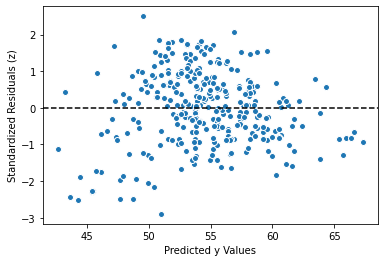

In [14]:
plt.plot(p65_mod_fit.fittedvalues, p65_mod_fit.resid_pearson, 
         'oC0',  
         markeredgecolor='white')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Predicted y Values')
plt.ylabel('Standardized Residuals (z)') 

We have n = 326 so normality not an issue. Residuals look relatively homogenous. 

# Multivariate Relations

First check for collinearity

In [15]:
Egdf[['Pct_Leave','Pct_Level4','Pct_65p']].corr()

,Pct_Leave,Pct_Level4,Pct_65p
Pct_Leave,1.000000,-0.881381,0.423744
Pct_Level4,-0.881381,1.000000,-0.269220
Pct_65p,0.423744,-0.269220,1.000000


Strong correlation between qualification variable and leave percentage. Less strong for age variable and leave percentage. Low correlation between qualification and age variables (so fine to include both). 

Fit the multiple regression model

In [16]:
l4_p65_mod = smf.ols("Pct_Leave ~ Pct_Level4 + Pct_65p", data=Egdf)
l4_p65_mod_fit = l4_p65_mod.fit()
print(l4_p65_mod_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Pct_Leave   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     708.3
Date:                Thu, 18 Mar 2021   Prob (F-statistic):          8.08e-119
Time:                        10:11:01   Log-Likelihood:                -938.80
No. Observations:                 326   AIC:                             1884.
Df Residuals:                     323   BIC:                             1895.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.2944      1.555     47.781      0.0

Check AIC and Adjusted $r^2$ - is this model better than the univariate models above?  (yes)

Check results - how have influence of variables changed?

Yes:

- effect of qualifications is very similar
- effect of age has reduced (due to 0.26 correlation). 

Check assumptions

Text(0, 0.5, 'Standardized Residuals (z)')

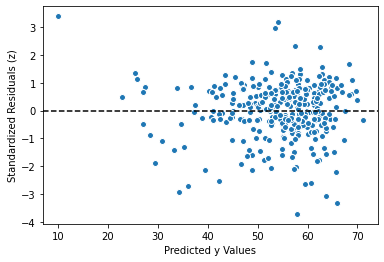

In [17]:
plt.plot(l4_p65_mod_fit.fittedvalues, l4_p65_mod_fit.resid_pearson, 
         'oC0',  
         markeredgecolor='white')
plt.axhline(linestyle = 'dashed', c = 'black')
plt.xlabel('Predicted y Values')
plt.ylabel('Standardized Residuals (z)') 

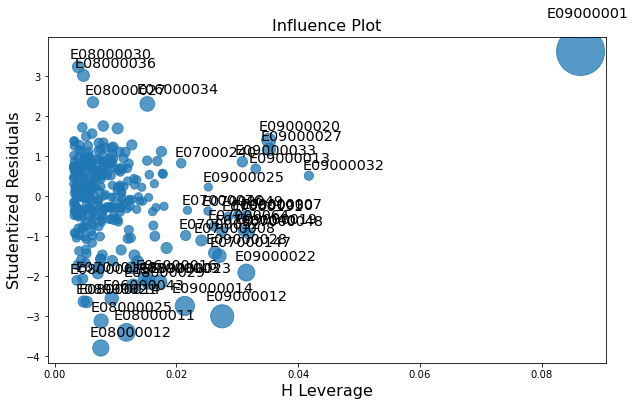

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(l4_p65_mod_fit, alpha=0.05, 
                                 criterion="cooks", ax=ax)

Point with id `E09000001` looks to have high leverage *and* be an outlier

In [19]:
Egdf.filter(like='E09000001',axis=0)

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,...,Pct_Rejected,Area,Count_Persons_quals,Pct_None,Pct_Level1,Pct_Level2,Pct_Apprentice,Pct_Level3,Pct_Level4,Pct_65p
E09000001,294,City of London,None,532382,181358,-0.09351,51.51564,0.000375,0.109886,"POLYGON ((-0.09679 51.52332, -0.10535 51.51854...",...,0.14,City of London,"6,755",6.7,4.3,6.6,0.7,7.2,68.4,14.1


This point is for City of London. Comparing variable values for the City with the univariate scatterplots above, we can see that the % of residents with a university qualification is high compared to all other local authorities. It is likely this high value that is causing the influence as shown above. 

To check the Cooks Distance $D$ we could access all values from the influence stats of the fitted model:

In [20]:
l4_p65_mod_fit.get_influence().cooks_distance[0]

array([4.04030702e-03, 1.66606632e-03, 4.53253131e-04, 1.13741189e-03,
       1.49571336e-03, 6.80304342e-04, 2.70173478e-05, 2.75560994e-04,
       6.69443652e-03, 4.33688637e-04, 2.73766763e-05, 2.97038782e-03,
       2.90982884e-06, 2.39851871e-03, 3.69962527e-03, 4.07539839e-05,
       1.31869508e-03, 2.12041508e-02, 4.21674186e-06, 9.72905472e-03,
       1.01827746e-03, 1.78910542e-03, 2.72520058e-03, 3.61727665e-03,
       1.90143108e-03, 8.89615031e-03, 3.18067216e-04, 9.59839427e-04,
       4.61337591e-03, 2.52721423e-04, 2.44369994e-05, 2.13000447e-08,
       1.06691749e-05, 1.10030907e-03, 1.74323477e-04, 2.70075797e-02,
       1.45082694e-03, 3.46527374e-03, 2.10414068e-03, 3.31751629e-06,
       5.74615021e-04, 1.87665103e-03, 1.97703892e-04, 2.03897305e-02,
       4.44998494e-04, 2.43228635e-04, 7.48174678e-05, 8.88102381e-04,
       4.49875897e-05, 2.98097021e-04, 9.24282923e-05, 6.56265501e-04,
       1.36912107e-02, 2.89867523e-08, 5.40585382e-02, 8.92021516e-04,
      

But which value is for the City of London??? 

To get the number of the row that corresponds to City of London:

In [21]:
Egdf.index.get_loc('E09000001')

318

Now use this to index the `cooks_distance` array: 

In [22]:
l4_p65_mod_fit.get_influence().cooks_distance[0][318]

0.3973563284324008

Is this a large $D$? Let's use the conservative threshold of $4/n$

In [23]:
dThresh = 4 / len(Egdf)
print(dThresh)

0.012269938650306749


Now find locations with $D$ > `dThresh`

In [24]:
gd = l4_p65_mod_fit.get_influence().cooks_distance[0]>dThresh

l4_p65_mod_fit.get_influence().cooks_distance[0][gd]

array([0.02120415, 0.02700758, 0.02038973, 0.01369121, 0.05405854,
       0.03948412, 0.02698708, 0.01650801, 0.01818125, 0.02074461,
       0.01237585, 0.02386724, 0.04484327, 0.03539853, 0.02446288,
       0.08342269, 0.02174836, 0.01320214, 0.01408819, 0.39735633,
       0.02360972])

So there's more than just City of London with influence greater than the conservative threshold. But $D$ for City is *so* much larger (10 times!) it's clear that data point likely has undue influence. Let's see the result when dropping the data for City of London 

In [25]:
Egdf_noCity = Egdf.drop('E09000001',axis=0)

In [26]:
l4_p65_mod_NC = smf.ols("Pct_Leave ~ Pct_Level4 + Pct_65p", data=Egdf_noCity)
l4_p65_mod_NC_fit = l4_p65_mod_NC.fit()
print(l4_p65_mod_NC_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Pct_Leave   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     716.6
Date:                Thu, 18 Mar 2021   Prob (F-statistic):          2.66e-119
Time:                        10:11:03   Log-Likelihood:                -929.95
No. Observations:                 325   AIC:                             1866.
Df Residuals:                     322   BIC:                             1877.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.2813      1.551     48.543      0.0

Results (regression coefficients, $r^2$) change a little

Now check assumptions:

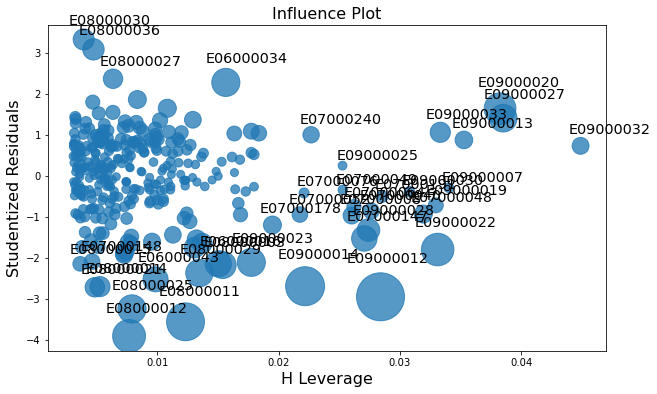

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(l4_p65_mod_NC_fit, alpha=0.05, 
                                 criterion="cooks", ax=ax)

I think we can be happy with this model. We can see that the regression coefficients for the two variables have changed slightly (and quite a lot given this is 1 outof 326 data points) by removing City of London, but the interpretation of the data remains the same. Of the variables considered here:

- qualification is a primary determinant of the propensity to vote leave (negative relationship)
- age is a secondary determinant of the propensity to vote leave (positive relationship)

But remember:

- we have considered only two variables here, and despite these being able to explain 82% of the variation in the vote leave % for England (which is a huge amount) there are still other factors that could be important (as the literature highlighted at the outset indicates)
- the 'ecological fallacy' - these results using aggregated data still can't predict how *individual people* voted. For example, there were still 'old' (over 65) non-university educated people that voted remain, and 'young' (under 65) university educated people that voted leave. 

# Further Resources

Goodwin and Heath (2016) The 2016 Referendum, Brexit and the Left Behind: An Aggregate‐level Analysis of the Result *Political Quarterly* 87(3) 323-332 [doi: 10.1111/1467-923X.12285](https://doi.org/10.1111/1467-923X.12285)

Chapter 10 in Harris (2016) *Quantitative Geography* London: SAGE

Chapter 7 in Harris and Jarvis (2011) *Statistics for Geography and Environmental Science* Harlow: Prentice-Hall

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).